# Detector de ataques a API REST con Random Forest + GridSearchCV

Este cuaderno entrena y evalúa un modelo **Random Forest** para clasificar peticiones como **normales** o **ataques** a partir de un CSV preprocesado (`/mnt/data/api_logs_ml_ready.csv`). Incluye:

- Carga y validación de datos
- Análisis exploratorio breve
- Preprocesado con `ColumnTransformer` + `OneHotEncoder`
- Entrenamiento con `GridSearchCV` para ajustar hiperparámetros
- Métricas (accuracy, precision, recall, F1, ROC-AUC)
- Matriz de confusión y curva ROC
- Importancias de características (Permutation Importance)
- Guardado del pipeline entrenado con `joblib`


In [1]:

# Dependencias
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt

from joblib import dump

CSV_PATH = 'api_logs_ml_ready.csv'  # Ajusta si tu CSV está en otro sitio
assert os.path.exists(CSV_PATH), f'No se encontró el CSV en {CSV_PATH}'
df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
df.head()


Shape: (590, 16)


,timestamp,http_method,endpoint,query_params_count,user_agent,authorization_present,ip_hash,content_length_bytes,num_fields,avg_field_length,failed_auth_attempts_last_10min,suspicious_patterns_detected,statusCode,duration_ms,responseSize,label_attack
0,2025-08-20T19:04:08.339Z,POST,/api/v1/auth/signup,0,python-requests/2.32.4,False,eff8e7ca506627fe15dda5e0e512fcaad70b6d520f37cc...,50,2,9.000000,1,suspicious_quotes_or_escape,403,557.14,44,1
1,2025-08-20T19:04:08.916Z,POST,/api/v1/auth/signin,0,python-requests/2.32.4,False,eff8e7ca506627fe15dda5e0e512fcaad70b6d520f37cc...,50,2,9.000000,1,suspicious_quotes_or_escape,201,344.61,244,1
2,2025-08-20T19:04:09.269Z,POST,/api/v1/book,0,python-requests/2.32.4,True,eff8e7ca506627fe15dda5e0e512fcaad70b6d520f37cc...,69,3,8.333333,1,"authorization_header_present,suspicious_quotes...",500,208.35,46,1
3,2025-08-20T19:04:09.487Z,GET,/api/v1/book,0,python-requests/2.32.4,True,eff8e7ca506627fe15dda5e0e512fcaad70b6d520f37cc...,0,0,0.000000,1,"authorization_header_present,suspicious_quotes...",200,42.65,14360,0
4,2025-08-20T19:04:09.569Z,POST,/api/v1/auth/signup,0,python-requests/2.32.4,False,eff8e7ca506627fe15dda5e0e512fcaad70b6d520f37cc...,50,2,9.000000,1,suspicious_quotes_or_escape,403,41.83,44,1


## 1) Análisis exploratorio rápido

In [2]:

# Tipos y valores faltantes
display(df.dtypes)
display(df.isna().mean().sort_values(ascending=False).head(20))

# Distribución de la etiqueta
if 'label_attack' not in df.columns:
    raise ValueError("No se encontró la columna 'label_attack' en el CSV. Asegúrate de que existe y es 0/1.")
print(df['label_attack'].value_counts(dropna=False))
df['label_attack'].value_counts(normalize=True).mul(100).round(2)


timestamp                           object
http_method                         object
endpoint                            object
query_params_count                   int64
user_agent                          object
authorization_present                 bool
ip_hash                             object
content_length_bytes                 int64
num_fields                           int64
avg_field_length                   float64
failed_auth_attempts_last_10min      int64
suspicious_patterns_detected        object
statusCode                           int64
duration_ms                        float64
responseSize                         int64
label_attack                         int64
dtype: object

timestamp                          0.0
http_method                        0.0
endpoint                           0.0
query_params_count                 0.0
user_agent                         0.0
authorization_present              0.0
ip_hash                            0.0
content_length_bytes               0.0
num_fields                         0.0
avg_field_length                   0.0
failed_auth_attempts_last_10min    0.0
suspicious_patterns_detected       0.0
statusCode                         0.0
duration_ms                        0.0
responseSize                       0.0
label_attack                       0.0
dtype: float64

label_attack
1    520
0     70
Name: count, dtype: int64


label_attack
1    88.14
0    11.86
Name: proportion, dtype: float64

## 2) Selección de variables

Ajusta las listas si tu dataset tiene columnas distintas.

In [3]:

# Definimos columnas candidatas
potential_features = [
    'http_method',
    'endpoint',
    'query_params_count',
    'user_agent',
    'authorization_present',
    'ip_hash',
    'content_length_bytes',
    'num_fields',
    'avg_field_length',
    'failed_auth_attempts_last_10min',
    'suspicious_patterns_detected',
    'statusCode',
    'duration_ms',
    'responseSize'
]

existing_features = [c for c in potential_features if c in df.columns]
missing = set(potential_features) - set(existing_features)
print("Usando features:", existing_features)
if missing:
    print("Aviso: no se encontraron estas columnas y serán ignoradas:", missing)

X = df[existing_features].copy()
y = df['label_attack'].astype(int)

# Convertimos tipos: booleanos a int, listas/strings a string
for col in X.columns:
    if X[col].dtype == bool:
        X[col] = X[col].astype(int)
    if X[col].dtype == object:
        X[col] = X[col].astype(str)


Usando features: ['http_method', 'endpoint', 'query_params_count', 'user_agent', 'authorization_present', 'ip_hash', 'content_length_bytes', 'num_fields', 'avg_field_length', 'failed_auth_attempts_last_10min', 'suspicious_patterns_detected', 'statusCode', 'duration_ms', 'responseSize']


## 3) Split entrenamiento / validación

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((442, 14), (148, 14))

## 4) Pipeline de preprocesado + modelo con GridSearchCV

In [5]:

# Definimos columnas numéricas y categóricas de forma automática
numeric_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
categorical_cols = [c for c in X.columns if c not in numeric_cols]

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)

clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipe = Pipeline(steps=[('prep', preprocess), ('rf', clf)])

# Grid de hiperparámetros
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print("Mejor score medio en CV:", grid_search.best_score_)

best_pipe = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.7s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.5s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=5, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=300; total

## 5) Evaluación del mejor modelo


Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        18
           1     1.0000    1.0000    1.0000       130

    accuracy                         1.0000       148
   macro avg     1.0000    1.0000    1.0000       148
weighted avg     1.0000    1.0000    1.0000       148

Matriz de confusión:
 [[ 18   0]
 [  0 130]]
ROC-AUC: 1.0000


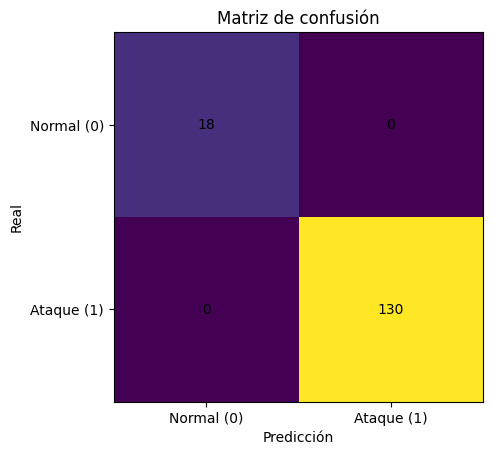

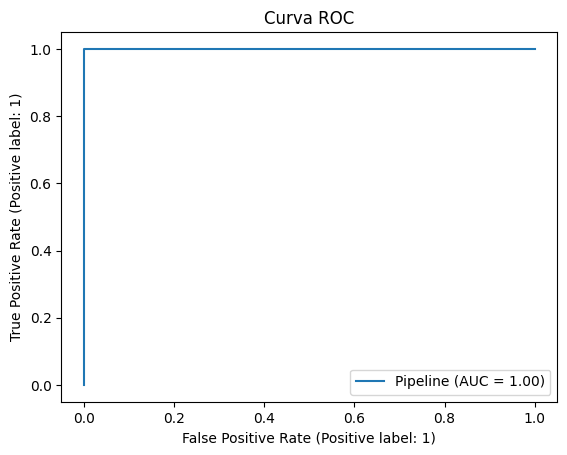

In [6]:

y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1]

print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:\n", cm)

try:
    auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {auc:.4f}")
except Exception as e:
    print("No se pudo calcular ROC-AUC:", e)

# Plot matriz de confusión
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_title('Matriz de confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Normal (0)', 'Ataque (1)'])
ax.set_yticklabels(['Normal (0)', 'Ataque (1)'])
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha='center', va='center')
plt.show()

# Plot curva ROC
try:
    RocCurveDisplay.from_estimator(best_pipe, X_test, y_test)
    plt.title('Curva ROC')
    plt.show()
except Exception as e:
    print("No se pudo trazar la curva ROC:", e)


## 6) Importancia de características (Permutation Importance)

In [7]:

# Calculamos permutation importance en el conjunto de test
result = permutation_importance(best_pipe, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)

# Extraemos nombres de las features transformadas
prep = best_pipe.named_steps['prep']
feature_names = []
for name, trans, cols in prep.transformers_:
    if name == 'remainder' and trans == 'drop':
        continue
    if hasattr(trans, 'get_feature_names_out'):
        fn = trans.get_feature_names_out(cols)
        feature_names.extend(fn)
    elif cols is not None:
        feature_names.extend(cols)

print("Nombres de features generados:", len(feature_names))
print("Importancias calculadas:", len(result.importances_mean))

min_len = min(len(feature_names), len(result.importances_mean))

imp_df = pd.DataFrame({
    'feature': feature_names[:min_len],
    'importance_mean': result.importances_mean[:min_len]
}).sort_values('importance_mean', ascending=False)

imp_df.head(20)


Nombres de features generados: 133
Importancias calculadas: 14


,feature,importance_mean
13,endpoint_/api/v1/book/%3B,0.024324
11,endpoint_/api/v1/book/%27,0.009459
0,http_method_DELETE,0.000000
1,http_method_GET,0.000000
2,http_method_PATCH,0.000000
3,http_method_POST,0.000000
4,endpoint_/api/v1/auth/7333449377685657536,0.000000
5,endpoint_/api/v1/auth/signin,0.000000
6,endpoint_/api/v1/auth/signup,0.000000
7,endpoint_/api/v1/book,0.000000


## 7) Guardar el pipeline entrenado

In [8]:

MODEL_PATH = 'random_forest_api_attack_detector_tuned.joblib'
dump(best_pipe, MODEL_PATH)
print(f'Modelo guardado en: {MODEL_PATH}')


Modelo guardado en: random_forest_api_attack_detector_tuned.joblib


## 8) Próximos pasos

- Ajustar el grid de hiperparámetros (más valores, RandomizedSearchCV para eficiencia).
- Añadir más señales (ventanas temporales, tasas por IP, ASN, geolocalización).
- Reentrenar periódicamente con datos recientes.
- Monitorizar drift y métricas en producción.
